# Preprocess Dataset

- 1. output data to dvij-in-the-wild/2024-02-xx.csv

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
import os
# from offroad.utils import load_state, lla_to_utm, lla_to_xy
import json
# import ipywidgets as widgets
# from car_dynamics.models_torch.dataset import clean_random_data
# from car_dynamics.analysis import pos2vel_savgol, calc_delta, interpolate, rotate_point, calc_delta_v

# from ipywidgets import interact
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
import os
import pickle
from rich.progress import track
from termcolor import colored
import numpy as np
import pyproj
import math

def determine_utm_zone(longitude):
    """Determine the UTM zone for a given longitude"""
    return int((longitude + 180) / 6) + 1

def lla_to_utm(lat, lon):
    """Convert LLA to UTM coordinates"""
    zone = determine_utm_zone(lon)
    utm_proj = pyproj.Proj(proj='utm', zone=zone, ellps='WGS84')
    x, y = utm_proj(lon, lat)
    return x, y

def quaternion_to_euler(input):
    """ quat: [x,y,z,w] -> [roll, pitch, yaw]
    Convert a quaternion into euler angles (roll, pitch, yaw)
    roll is rotation around x-axis, pitch is rotation around y-axis
    and yaw is rotation around z-axis.
    """
    # Normalize the quaternion
    x, y, z, w = input
    magnitude = math.sqrt(x**2 + y**2 + z**2 + w**2)
    x, y, z, w = x / magnitude, y / magnitude, z / magnitude, w / magnitude

    # Roll (x-axis rotation)
    sinr_cosp = 2 * (w * x + y * z)
    cosr_cosp = 1 - 2 * (x**2 + y**2)
    roll = math.atan2(sinr_cosp, cosr_cosp)

    # Pitch (y-axis rotation)
    sinp = 2 * (w * y - z * x)
    if abs(sinp) >= 1:
        # Use 90 degrees if out of range
        pitch = math.copysign(math.pi / 2, sinp)
    else:
        pitch = math.asin(sinp)

    # Yaw (z-axis rotation)
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y**2 + z**2)
    yaw = math.atan2(siny_cosp, cosy_cosp)

    return roll, pitch, yaw
def load_state(path, log_range: list, orientation_provider='imu', verbose=0):
    """ Given absolute path to the log directory, load the state (position, yaw, action) of the car.
        orientation_provider: [ imu or zed2_odom or vesc_odom ]
    """
    log_num = 0
    obs = []
    p = []
    p_vicon = []
    gps = []
    pdot = []
    yaw_imu = []
    yaw_vesc = []
    yaw_vesc_ang_vel = []
    yaw_zed2 = []
    yaw_zed2_ang_vel = []
    yaw_vicon = []
    actions = []
    mppi_actions = []
    mppi_sample_actions = []
    targets = []
    mppi_traj = []
    is_recover = []
    t = []
    date = []
    for log_num in track(range(log_range[0], log_range[1]), disable=True if verbose == 0 else False):
        with open(os.path.join(path, f"log{log_num}.pkl"), "rb") as f:
            data = pickle.load(f)
        log_num += 1
        for d_t in data:
            # print(d_t)
            t.append(d_t['time'])
            if 'gps' in d_t:
                gps.append(d_t['gps'])
            if 'date' in d_t:
                date.append(d_t['date'])
            # if 'gps_loc' in d_t:
            #     p.append(d_t['gps_loc'][:2])
            # if 'gps_vel' in d_t:
            #     pdot.append(d_t['gps_vel'][:2])
            if 'vicon_loc' in d_t and d_t['vicon_loc'] is not None:
                p_vicon.append(d_t['vicon_loc'][:2])
                yaw_vicon.append(d_t['vicon_loc'][2])
                
            if 'mppi_actions' in d_t:
                mppi_actions.append(d_t['mppi_actions'])
                
            if 'targets' in d_t:
                targets.append(d_t['targets'])
            
            if 'mppi_traj' in d_t:
                mppi_traj.append(d_t['mppi_traj'])
                
            if 'mppi_sample_actions' in d_t:
                mppi_sample_actions.append(d_t['mppi_sample_actions'])
            
            if 'recover' in d_t:
                is_recover.append(d_t['recover'])
                
            if 'imu' in d_t:  
                if d_t['imu'] is not None:
                    yaw_imu.append(quaternion_to_euler(d_t['imu']['orientation'])[-1])
                    yaw_zed2_ang_vel.append(d_t['imu']['angular_vel'][-1])
            if 'vesc_odom' in d_t:
                if d_t['vesc_odom'] is not None:      
                    yaw_vesc.append(quaternion_to_euler(d_t['vesc_odom']['orientation'])[-1])
                    yaw_vesc_ang_vel.append(d_t['vesc_odom']['angular_vel'][-1])
            if 'zed2_odom' in d_t:
                if d_t['zed2_odom'] is not None:
                    yaw_zed2.append(quaternion_to_euler(d_t['zed2_odom']['orientation'])[-1])
            actions.append([d_t['throttle'], d_t['steering']])
            obs.append(d_t['obs'])

    if verbose == 1:
        print(colored(f"[INFO] In total {log_range[1] - log_range[0]} logs", 'green'))
    
    gps_locations = np.array(p)
    if len(gps_locations) != 0:
        # Taking the first location as the reference point
        reference_point_utm = lla_to_utm(gps_locations[0][0], gps_locations[0][1])
        utm_coords = []

        for lat, lon in gps_locations:
            if np.isnan(lon):
                continue
            # print(lon)
            x, y = lla_to_utm(lat, lon)
            utm_coords.append([x, y])

        # Subtracting the reference point to get relative coordinates
        utm_coords = np.array(utm_coords) - reference_point_utm
        p = utm_coords
    p_vicon = np.array(p_vicon)
    
    # pdot = np.array(pdot)
    t = np.array(t)
    yaw_imu = np.array(yaw_imu)
    yaw_zed2 = np.array(yaw_zed2)
    yaw_zed2_ang_vel = np.array(yaw_zed2_ang_vel)
    yaw_vesc = np.array(yaw_vesc)
    yaw_vesc_ang_vel = np.array(yaw_vesc_ang_vel)
    yaw_vicon = np.array(yaw_vicon)
    actions = np.array(actions)
    obs = np.array(obs)
    mppi_actions = np.array(mppi_actions)
    # targets = np.array(targets)
    mppi_sample_actions = np.array(mppi_sample_actions)
    mppi_traj = np.array(mppi_traj)
    is_recover = np.array(is_recover)
    
    return t, \
            {'gps': gps, 'vicon': p_vicon, 'obs': obs, 'date': date}, \
            {'imu': yaw_imu, 'vesc': yaw_vesc, 'zed2': yaw_zed2, 'vicon': yaw_vicon, 'zed2_ang_vel': yaw_zed2_ang_vel, 'vesc_ang_vel': yaw_vesc_ang_vel,}, \
            actions, \
            {'mppi_actions': mppi_actions, 'targets': targets, 'mppi_traj': mppi_traj,
             'mppi_sample_actions': mppi_sample_actions,
             'is_recover': is_recover} #controller info
    

## In the wild

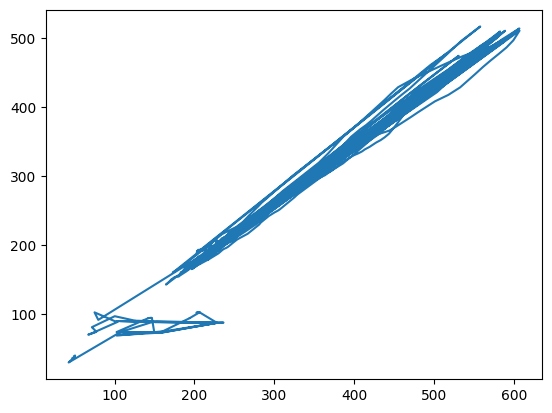

In [36]:
# dump GPS data to .csv file

gps_data_list = [
    # dict(name='wild', dir='data-20240219-000025', range=[0, 95]),
    # dict(name='wild', dir='data-20240219-000148', range=[0, 86]),
    # dict(name='wild', dir='data-20240219-000314', range=[0, 35]),
    # dict(name='wild', dir='data-20240219-000408', range=[0, 68]),
    # dict(name='wild', dir='data-20240219-000548', range=[0, 33]),
    # dict(name='wild', dir='data-20240219-000643', range=[0, 70]),
    # dict(name='wild', dir='data-20240219-000800', range=[0, 158]),
    # dict(name='wild', dir='data-20240219-001005', range=[0, 101]),
    # dict(name='wild', dir='data-20240219-001129', range=[0, 50]),
    # dict(name='wild', dir='data-20240219-001311', range=[0, 57]),
    dict(name='wild', dir='data-20240227-221134', range=[0, 669]),
]

for config in gps_data_list:
    log_dir = '/Users/wenlixiao/Dropbox/School/Graduate/LeCAR/safe-learning-control/playground/offroad/' + f"data/{config['dir']}"
    log_dir_clean = '/Users/wenlixiao/Dropbox/School/Graduate/LeCAR/safe-learning-control/playground/offroad/data/wild-data-clean/'
    
    with open(os.path.join(log_dir, 'header.json')) as f:
        header_info = json.load(f)
    t_list, p_dict, yaw_dict, action_list, controller_info = load_state(log_dir, config['range'], orientation_provider="ORIENTATION_PROVIDOER")
    # obs_np = p_dict['obs']
    obs_gps = p_dict['gps']
    pos = []
    for gps in obs_gps:
        if gps is None:
            loc = [np.nan, np.nan]
        else:
            gps_loc = gps['loc']
            # loc = lla_to_utm(gps_loc[0], gps_loc[1])
            loc = lla_to_xy(gps_loc[0], gps_loc[1])
        pos.append(loc)
    pos = np.array(pos) / 100
    # pos = np.array(pos) 
    plt.plot(pos[:,0], pos[:,1])
    gps_dataset = pd.DataFrame({'date': p_dict['date'], 'time': t_list, 'pos_x': pos[:,0], 'pos_y': pos[:,1],})
    gps_dataset.dropna()
    gps_dataset.to_csv(os.path.join(log_dir_clean, f'gps-{config["dir"]}.csv'), index=False)

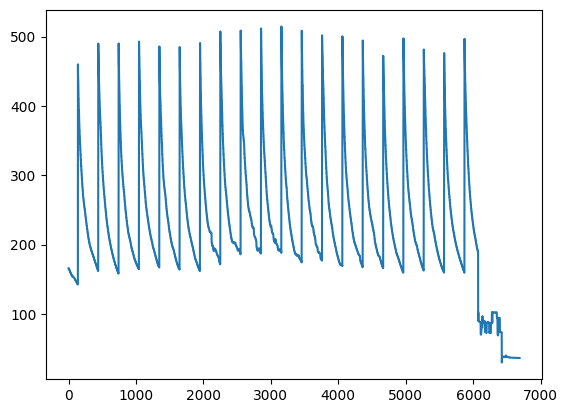

In [24]:
plt.plot(pos[:, 1])

In [9]:
# standardize the time in the IMU/VESC data
for i in range(1, 2):
    log_dir = '/Users/wenlixiao/Dropbox/School/Graduate/LeCAR/safe-learning-control/playground/offroad/data/wild-imu/'
    log_dir_clean = '/Users/wenlixiao/Dropbox/School/Graduate/LeCAR/safe-learning-control/playground/offroad/data/wild-data-clean/'
    IMU_FILE = f'wild-feb-27-1-imu-data.csv'
    VESC_FILE = f'wild-feb-27-1-vesc-joy.csv'
    CLEAN_IMU_FILE = f'wild-feb-27-1-imu-data-clean.csv'
    CLEAN_VESC_FILE = f'wild-feb-27-1-vesc-joy-clean.csv'

    imu_dataset = pd.read_csv(os.path.join(log_dir, IMU_FILE))
    imu_time = imu_dataset['.header.stamp.secs'].to_numpy() + imu_dataset['.header.stamp.nsecs'].to_numpy() / (10**9)
    imu_ang_vel = imu_dataset['.angular_velocity.z'].to_numpy()
    imu_dataset = pd.DataFrame({'date': imu_dataset['time'], 'time': imu_time, 'ang_vel': imu_ang_vel})
    imu_dataset.dropna()
    imu_dataset.to_csv(os.path.join(log_dir_clean, CLEAN_IMU_FILE), index=False)

    vesc_dataset = pd.read_csv(os.path.join(log_dir, VESC_FILE))
    vesc_time = vesc_dataset['.header.stamp.secs'].to_numpy() + vesc_dataset['.header.stamp.nsecs'].to_numpy() / (10**9)
    vesc_data = np.array([eval(command) for command in vesc_dataset['.axes'].tolist()])
    vesc_dataset = pd.DataFrame({'date': vesc_dataset['time'], 'time': vesc_time, 'target_vel': vesc_data[:, 1], 'target_steer': vesc_data[:, 2]})
    vesc_dataset.dropna()
    vesc_dataset.to_csv(os.path.join(log_dir_clean, CLEAN_VESC_FILE), index=False)

In [5]:
# Find match time interval for GPS and IMU/VESC data
log_dir_clean = '/Users/wenlixiao/Dropbox/School/Graduate/LeCAR/safe-learning-control/playground/offroad/data/wild-data-clean/'

plt.figure(figsize=(20,10))
# all_files = sorted(os.listdir(log_dir_clean))
file_pairs = [
    ['gps-data-20240227-221134.csv', 'wild-feb-27-1-imu-data-clean.csv', 'wild-feb-27-1-vesc-joy-clean.csv',],
]

num_data = 0

dataset_list = dict()
for i, files in enumerate(file_pairs):
    gps = pd.read_csv(os.path.join(log_dir_clean, files[0]),)
    imu = pd.read_csv(os.path.join(log_dir_clean, files[1]),)
    vesc = pd.read_csv(os.path.join(log_dir_clean, files[2]),)
    
    
    lower_threshold = max(gps['time'].min(), imu['time'].min(), vesc['time'].min())
    upper_threshold = min(gps['time'].max(), imu['time'].max(), vesc['time'].max())
    
    gps = gps[(gps['time'] > lower_threshold) & (gps['time'] < upper_threshold)]
    imu = imu[(imu['time'] > lower_threshold) & (imu['time'] < upper_threshold)]
    vesc = vesc[(vesc['time'] > lower_threshold) & (vesc['time'] < upper_threshold)]
    # filtered_df = df[(df['time'] > lower_threshold) & (df['time'] < upper_threshold)]
    
    
    gps_time = gps['time'].to_numpy()
    gps_pos = gps[['pos_x', 'pos_y']].to_numpy()
    gps_time, gps_pos = interpolate(gps_time, gps_pos, frequency=1000)
    
    plt.plot(imu['time'], imu['ang_vel'], label='original')
    imu_time = imu['time'].to_numpy()
    imu_ang_vel = np.expand_dims(imu['ang_vel'].to_numpy(), -1)
    
    imu_time, imu_ang_vel = interpolate(imu_time, imu_ang_vel, frequency=1000)
    
    vesc_time = vesc['time'].to_numpy()
    vesc_command = vesc[['target_vel', 'target_steer']].to_numpy()
    vesc_time, vesc_command = interpolate(vesc_time, vesc_command, frequency=1000)
    
    # sync time
    lower_threshold = max(gps_time.min(), imu_time.min(), vesc_time.min())
    upper_threshold = min(gps_time.max(), imu_time.max(), vesc_time.max())
    
    gps_time_new = gps_time[(gps_time > lower_threshold) & (gps_time < upper_threshold)]
    gps_pos = gps_pos[(gps_time > lower_threshold) & (gps_time < upper_threshold)]
    imu_time_new = imu_time[(imu_time > lower_threshold) & (imu_time < upper_threshold)]
    imu_ang_vel = imu_ang_vel[(imu_time > lower_threshold) & (imu_time < upper_threshold)]
    vesc_time_new = vesc_time[(vesc_time > lower_threshold) & (vesc_time < upper_threshold)]
    vesc_command = vesc_command[(vesc_time > lower_threshold) & (vesc_time < upper_threshold)]
    
    dataset_length = min(len(gps_time_new), len(imu_time_new), len(vesc_time_new))
    print(gps_time_new.min(), imu_time_new.min(), vesc_time_new.min())
    new_df = pd.DataFrame({'time': gps_time_new[:dataset_length], 'pos_x': gps_pos[:dataset_length, 0], 'pos_y': gps_pos[:dataset_length, 1], 'imu_ang_vel': imu_ang_vel[:dataset_length, 0], 
                           'target_vel': vesc_command[:dataset_length, 0], 'target_steer': vesc_command[:dataset_length, 1]})
    
    new_df_20Hz = new_df.iloc[::50, :]
    dataset_list[files[0][:-4]] = new_df_20Hz
    new_df_20Hz.to_csv(os.path.join(log_dir_clean, f'wild{i}-sync.csv'), index=False)
    num_data += new_df_20Hz.shape[0]
    plt.plot(new_df_20Hz['time'].to_numpy(), new_df_20Hz['pos_y'].to_numpy(), label='resample')    
    # plt.plot(gps['time'], np.ones(len(gps['time'])), color='r' )
    # plt.plot(imu['time'], np.ones(len(imu['time']))*1.1, color='g')
    # plt.plot(vesc['time'], np.ones(len(vesc['time']))*1.2, color='b')
    # # plt.plot(gps['time'][:1], [3])
    # plt.ylim([0, 3])
    plt.xlabel("wall-clock time")
    # plt.xlabel("wall-clock time")
    # plt.ylabel("angular velocity")
plt.legend()
print(num_data)
joblib.dump(dataset_list, os.path.join(log_dir_clean, 'wild-sync-dataset-feb-27.pkl'))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/wenlixiao/Dropbox/School/Graduate/LeCAR/safe-learning-control/playground/offroad/data/wild-data-clean/gps-data-20240227-221134.csv'

<Figure size 2000x1000 with 0 Axes>

## Vicon

(2050, 7)
C:/Users/dvijk/vicon/car_dynamics/traj_files/vicon-data-clean/vicon-circle-data-20240305-002436.csv


Text(0, 0.5, 'y (m)')

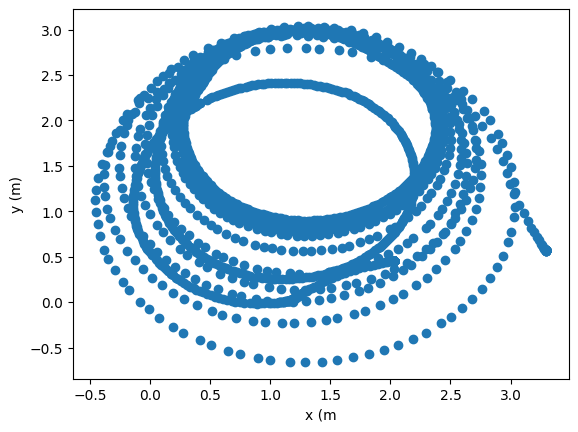

In [23]:
# dump Vicon data to .csv file

gps_data_list = [
    # dict(name='vicon-circle-1',dir='data-20240225-215328', range=[0, 274], clip=[0, 2730]),
    # dict(name='vicon-circle-1',dir='data-20240301-140048', range=[0, 99], clip=[0, 990]),
    dict(name='vicon-circle-1',dir='data-20240305-002436', range=[0,205], clip=[0, -1]),
]

TYPE = 'circle'

for config in gps_data_list:
    log_dir = 'C:/Users/dvijk/vicon/car_collect/data/' + f"{config['dir']}"
    log_dir_clean = 'C:/Users/dvijk/vicon/car_dynamics/traj_files/vicon-data-clean/'
    
    with open(os.path.join(log_dir, 'header.json')) as f:
        header_info = json.load(f)
    t_list, p_dict, yaw_dict, action_list, controller_info = load_state(log_dir, config['range'], orientation_provider="ORIENTATION_PROVIDOER")
    obs_np = p_dict['obs']
    print(obs_np.shape)
    obs_np = obs_np[config['clip'][0]:config['clip'][1], :]
    action_list = action_list[config['clip'][0]:config['clip'][1], :]
    p_dict['date'] = p_dict['date'][config['clip'][0]:config['clip'][1]]
    t_list = t_list[config['clip'][0]:config['clip'][1]]
    vicon_dataset = pd.DataFrame({'date': p_dict['date'], 'time': t_list, 'pos_x': obs_np[:, 0], 'pos_y': obs_np[:, 1],'yaw': obs_np[:, 2], 'target_vel': action_list[:, 0], 'target_steer': action_list[:, 1]})
    vicon_dataset.dropna()
    vicon_dataset.to_csv(os.path.join(log_dir_clean, f'vicon-{TYPE}-{config["dir"]}.csv'), index=False)
    plt.scatter(obs_np[:, 0], obs_np[:, 1])
    print(os.path.join(log_dir_clean, f'vicon-{TYPE}-{config["dir"]}.csv'))
plt.xlabel("x (m")
plt.ylabel("y (m)")

### Cut useless data

In [127]:
df = pd.read_csv('/Users/wenlixiao/Dropbox/School/Graduate/LeCAR/safe-learning-control/playground/offroad/data/dataset/vicon-data-clean/vicon-circle-data-20240304-160621.csv')

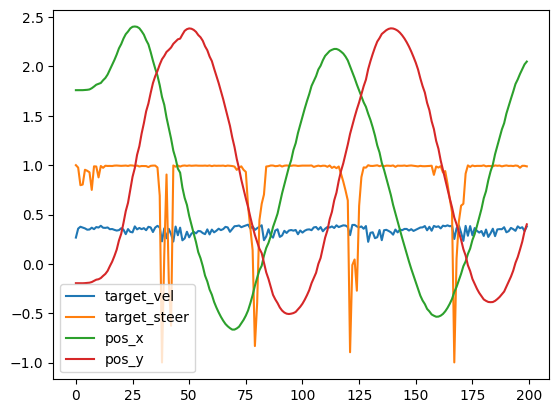

In [128]:
df_increase = df.loc[:]
plt.plot(df_increase['target_vel'], label='target_vel')
plt.plot(df_increase['target_steer'], label='target_steer')
plt.plot(df_increase['pos_x'], label='pos_x')
plt.plot(df_increase['pos_y'], label='pos_y')
plt.legend()
# df_increase.to_csv('/Users/wenlixiao/Dropbox/School/Graduate/LeCAR/safe-learning-control/playground/offroad/data/dataset/vicon-data-clean/vicon-circle-data-20240303-232422-1.csv', index=False)